In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
from importlib import reload

import torch
import numpy as np
import sciplots as plots
import matplotlib.pyplot as plt
from matplotlib import patches
from sklearn.decomposition import PCA

from src import main
from src.utils import data
from src.utils.utils import open_config
from src.utils.clustering import CompactClusterEncoder

torch.serialization.add_safe_globals([CompactClusterEncoder])
reload(data)
reload(main)
from src.main import init

In [2]:
_, config = open_config('main', '../config.yaml')

net_epochs = config['training']['epochs']
states_dir = config['output']['network-states-directory']
plots_dir = config['output']['plots-directory']

bahamas_colours = ['#0049E0', '#0090E0', '#00D7E0', '#2CDEE6', '#00E09E', '#00E051'][:-2]
bahamas_agn_colours = ['#F54EDF', '#5D4EF5']
bahamas_dmo = ['#00FA8F', '#01FB3D', '#89FA00']
flamingo_colours = ['#FABD00', '#FA2100', '#FA7700']
flamingo_test = ['#FA07A0']
# colours = ['k'] + bahamas_dmo[:1] + bahamas_agn_colours + bahamas_colours[:2] + bahamas_dmo[-1:] + bahamas_colours[2:]
colours = ['k'] + bahamas_agn_colours + bahamas_colours

In [4]:
known = [
    # 'flamingo',
    # 'flamingo_low',
    # 'flamingo_hi',
    'bahamas_cdm',
    'bahamas_cdm_low',
    'bahamas_cdm_hi',
    'bahamas_0.1',
    'bahamas_0.3',
    'bahamas_1',
    # 'darkskies_cdm',
    # 'darkskies_0.2',
]
# unknown = ['bahamas_dmo_cdm', 'bahamas_dmo_0.1', 'bahamas_dmo_1', 'flamingo_low_test', 'noise']
# unknown = ['flamingo_low_test']
unknown = ['darkskies_0.1']

loaders, net, dataset = init(known, config, unknown=unknown)

data = net.predict(loaders[1])
data['targets'] = dataset.unique_labels(data['targets'], dataset.sims[data['ids'].astype(int)])
# data['targets'] = dataset.correct_unknowns(data['targets'].squeeze())
data['targets'] = data['targets'].squeeze()
labels = dataset.names[data['ids'][np.unique(
    data['targets'],
    return_index=True,
)[1]].astype(int)].tolist()


Training data size: 18240	Validation data size: 4560
Prediction time: 1.446e+00 s


In [10]:
data['latent'][:, 0] *= 1e6
pca = PCA(n_components=4).fit(data['latent'][np.isin(data['targets'], np.unique(data['targets'])[net._unknown:])])
# pca = PCA(n_components=4).fit(data['latent'])
pca_transform = pca.transform(data['latent'])
pca_transform[:, 0] /= 1e6
data['latent'][:, 0] /= 1e6
pca_transform.shape

(4560, 4)

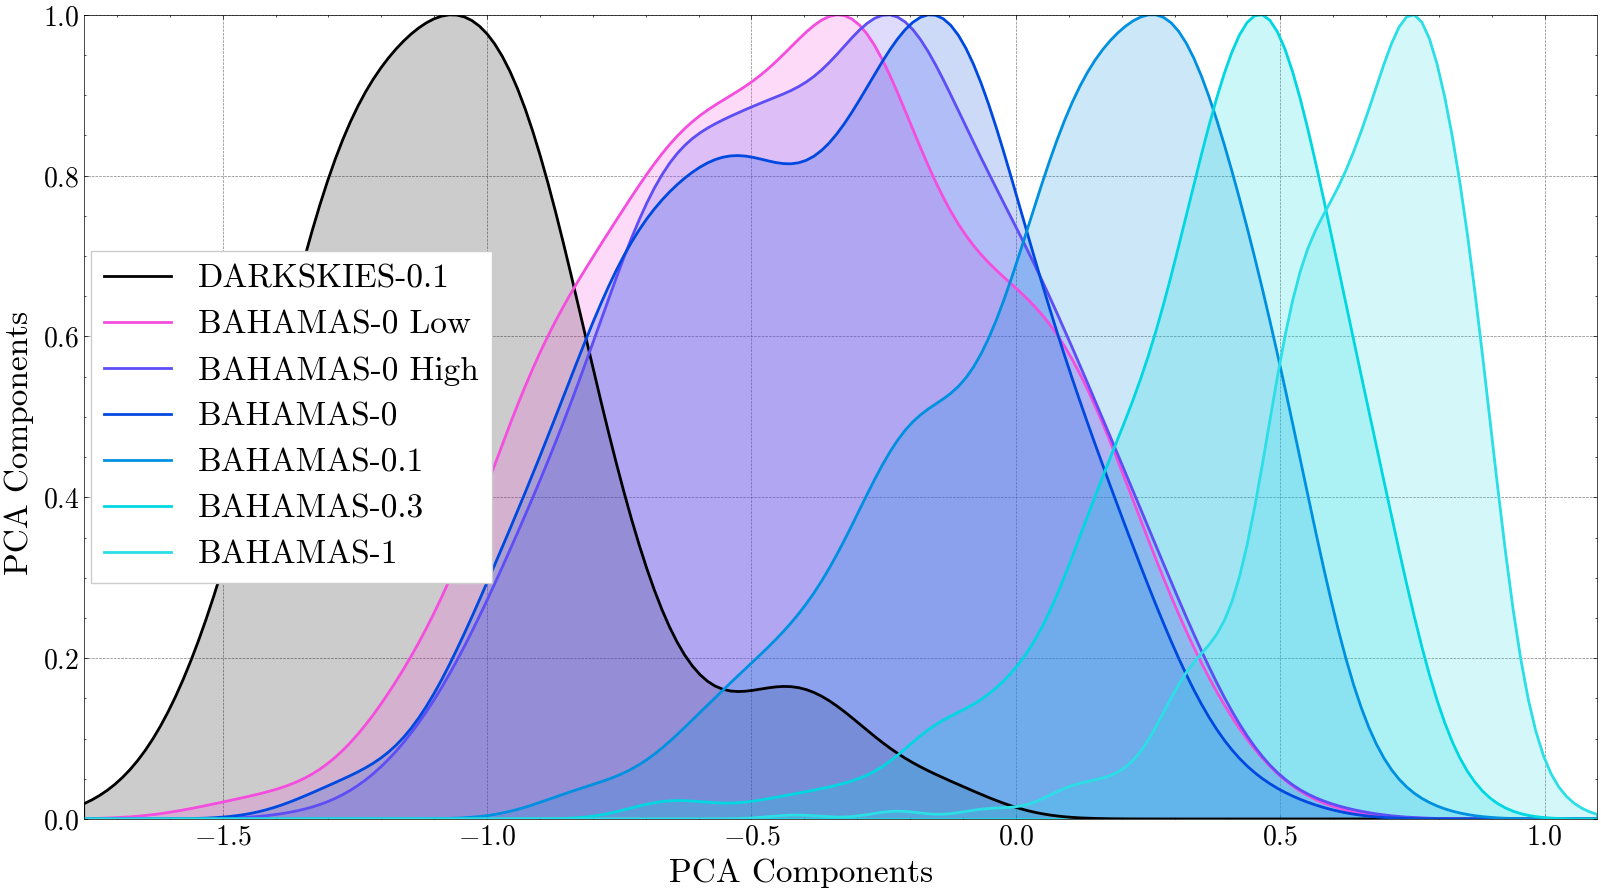

In [15]:
# idxs = np.isin(data['targets'].flatten(), np.unique(data['targets'])[0:])
idxs = slice(None)
plot = plots.PlotClusters(
    pca_transform[idxs, :1],
    data['targets'][idxs],
    norm=True,
    density=True,
    labels=labels,
    alpha_marker=0.2,
    alpha_2d=0.2,
    # colours=['k'] + flamingo_test + bahamas_dmo + flamingo_colours[1:2] + bahamas_colours,
    colours=colours,
    x_label='PCA Components',
    # y_label='PCA Components',
    cols=1,
    axis=True,
    loc='best',
)
# plot.axes[1, 0].set_xlim((np.min(pca_transform[:, 0] - np.abs(pca_transform[:, 0] * 0.05)), np.max(pca_transform[:, 0] + np.abs(pca_transform[:, 0] * 0.05))))
# plot.axes[1, 0].set_ylim((np.min(pca_transform[:, 1] - np.abs(pca_transform[:, 1] * 0.05)), np.max(pca_transform[:, 1] + np.abs(pca_transform[:, 1] * 0.05))))

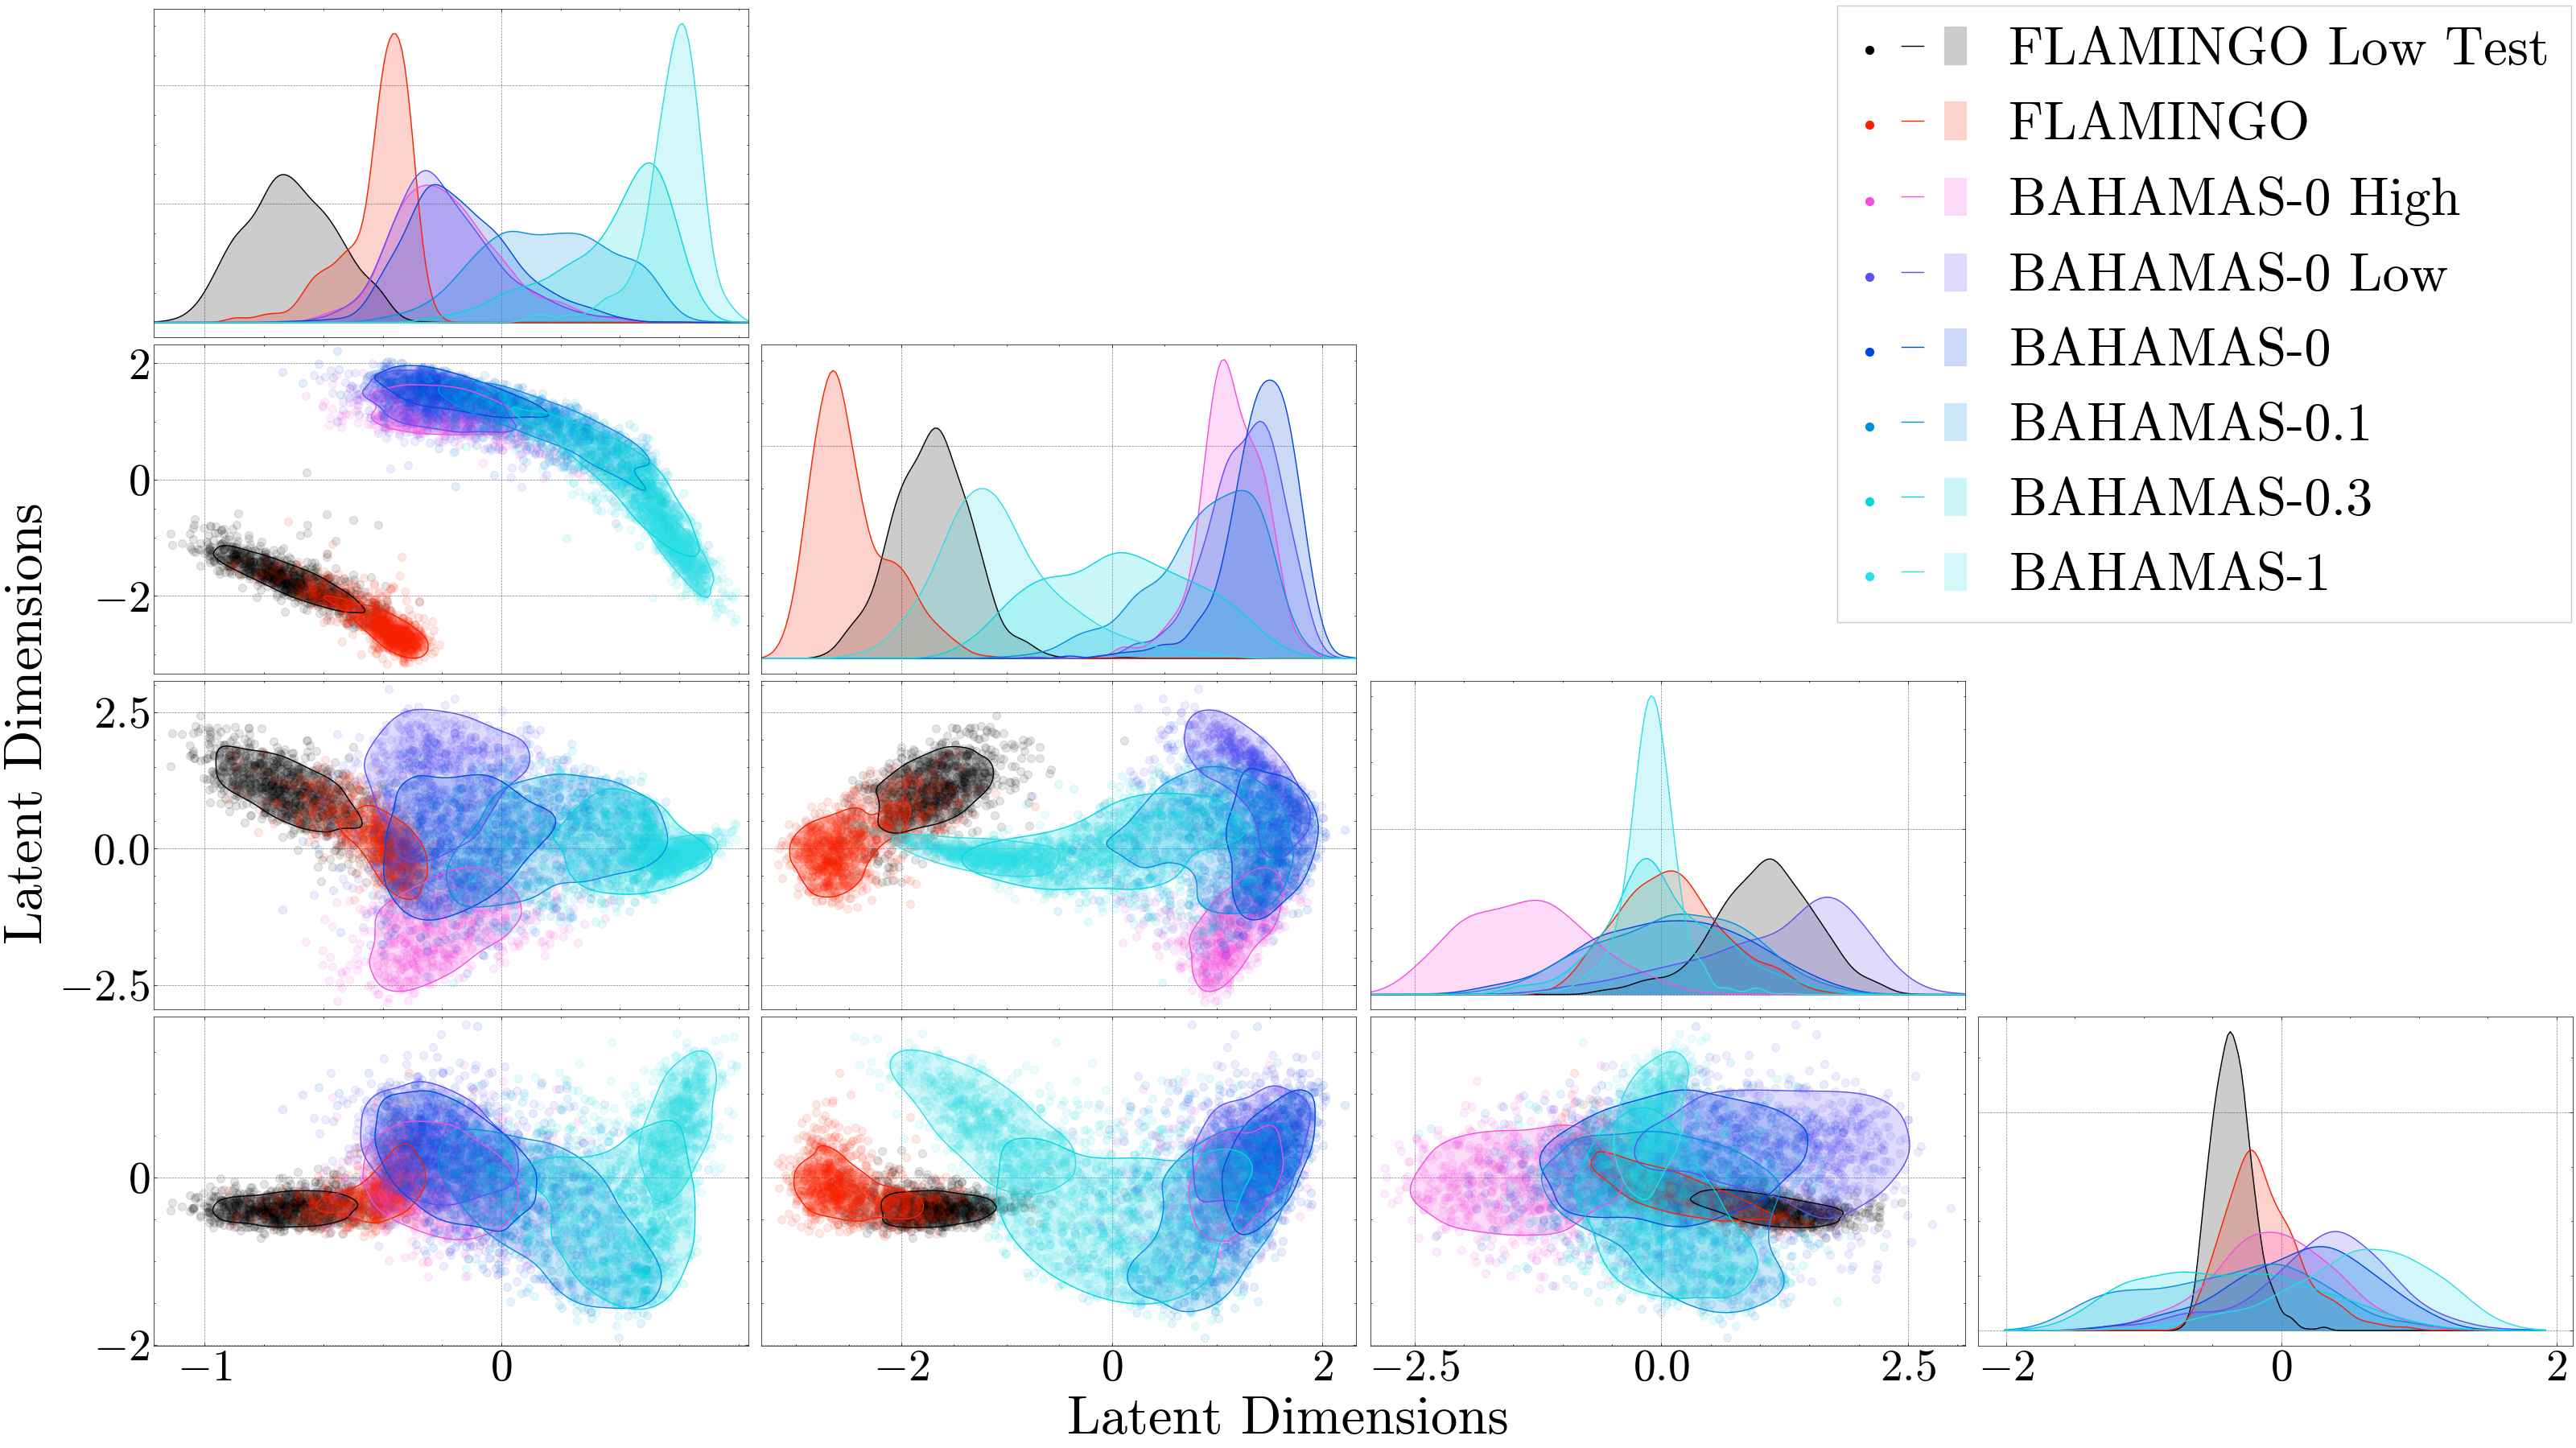

In [27]:
plot = plots.PlotClusters(
    # data['latent'],
    pca_transform,
    data['targets'],
    density=True,
    labels=labels,
    alpha=0.1,
    alpha_2d=0.2,
    colours=['k'] + flamingo_colours[2:] + bahamas_agn_colours + bahamas_colours,
    x_label='Latent Dimensions',
    y_label='Latent Dimensions',
    rows=len(labels),
    loc='upper right',
)

TypeError: BasePlot.create_legend() got an unexpected keyword argument 'frameon'

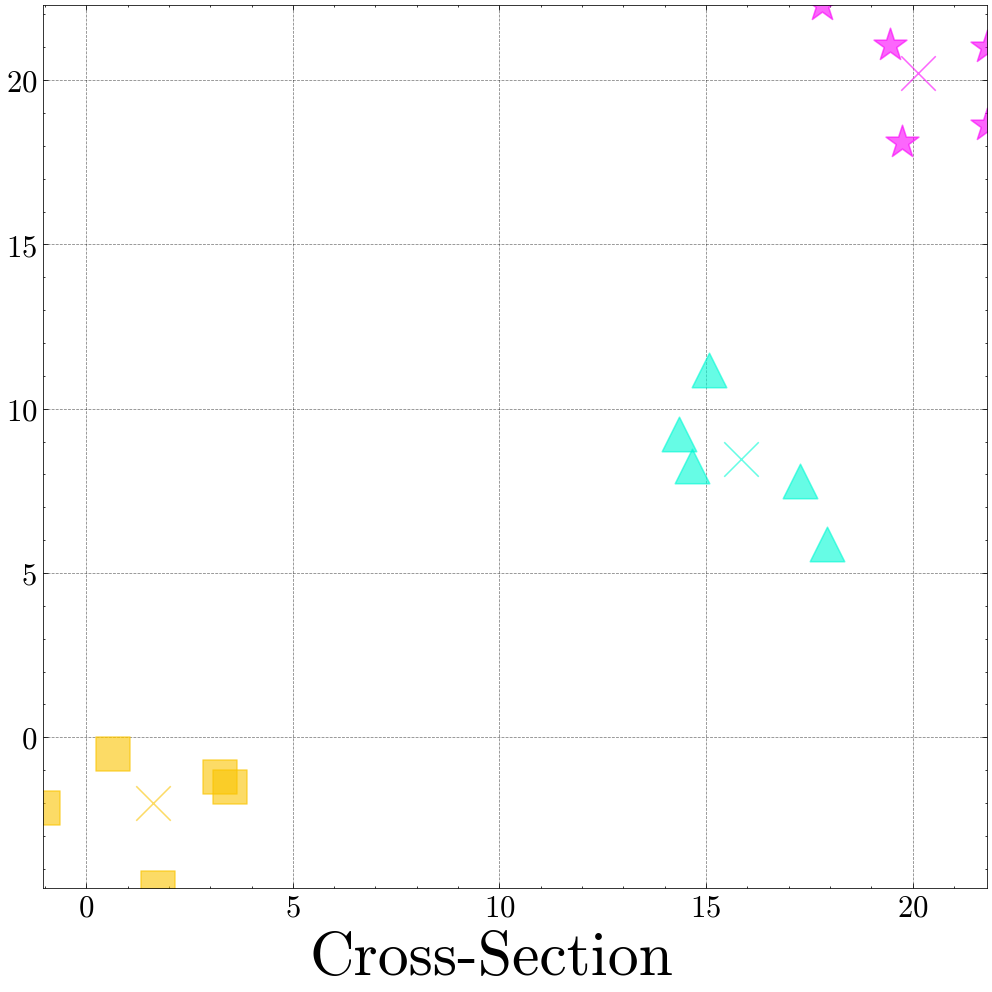

In [8]:
std = 4
np.random.seed(1)
data = np.array((
    np.random.multivariate_normal([0, 0], [[std, 0], [0, std]], size=5),
    np.random.multivariate_normal([15, 10], [[std, 0], [0, std]], size=5),
    np.random.multivariate_normal([20, 20], [[std, 0], [0, std]], size=5),
))

means = np.mean(data, axis=1)

plot = plots.PlotPlots(
    [*data[..., 0], *means[:, :1]],
    [*data[..., 1], *means[:, 1:]],
    fig_size=(10, 10),
    styles=['s', '^', '*', 'x', 'x', 'x'],
    colours=['#FAC400', '#00FAD4', '#FA00FA', '#FAC400', '#00FAD4', '#FA00FA'],
    x_label='Cross-Section',
    marker_size=500,
    labels=['Sim 1', 'Sim 2', 'Sim 3', 'Sim 1 Center', 'Sim 2 Center', 'Sim 3 Center'],
    axis=True,
    loc='best',
    cols=1,
    major=40,
    frameon=False,
)
plot.set_axes_pad(pad=0.1)
plot.axes.set_xticks([])
plot.axes.set_yticks([])

for i, point in enumerate(data[-1]):
    for point2 in data[-1, i + 1:]:
        plot.axes.plot([point[0], point2[0]], [point[1], point2[1]], c=plot._colours[-1], alpha=0.2)

    for point2 in data[1]:
        plot.axes.plot([point[0], point2[0]], [point[1], point2[1]], c=plot._colours[1], alpha=0.1)

plot.axes.add_patch(patches.FancyArrowPatch(means[0], means[1], arrowstyle='<|-|>', mutation_scale=40, lw=2, color='k'))
plot.axes.vlines(means[:, 0], np.min(data) * 0.1 * (np.max(data) - np.min(data)), means[:, 1], color='k')